In [ ]:
from pathlib import Path

import json

import pandas as pd
import numpy as np

In [ ]:
from ppi_utils.reduce import dedup_pairs
from ppi_utils.pairs import estimate_bias, estimate_bias_per_species
from ppi_utils.api import uniprot_api_fetch
from ppi_utils.extract import ppis_to_hashes
from ppi_utils.general import get_seq_hash, get_ids

## Extract PPIs from the original hu.MAP 2.0

In [ ]:
humap_dir = Path.cwd().parent / 'ppi_data/hu.MAP'
assert humap_dir.is_dir()
humap_dir

There is a train-test-split already!?

In [ ]:
humap = list()
for txt in sorted(humap_dir.glob('*.txt')):
    if 'complexes' in txt.stem:
        continue
    tx = pd.read_csv(txt, sep='\t', header=None, names=['ida', 'idb'])
    tx['label'] = 0 if 'neg' in txt.stem else 1
    tx['set_type'] = 'train' if 'train' in txt.stem else 'test'
    humap.append(tx)
humap = pd.concat(humap)

In [ ]:
humap.head()

In [ ]:
h = dedup_pairs(humap.copy())
len(humap), len(humap) - len(h), 'That\'s huuuuuge!'

In [ ]:
humap = h
humap.head()

In [ ]:
humap.set_type.value_counts()
# train-test-split of roughly equal size?!

In [ ]:
all_ids = dict()
for t in ['train', 'test']:
    h = humap.loc[humap.set_type == t]
    bias = estimate_bias(h)
    ids = set(h.ida) | set(h.idb)
    all_ids[t] = ids
    print(f'{t}:\tn_pairs = {len(h)}\tn_PPIs = {len(h.loc[h.label == 1])}\tbias = {bias[0]:.3f}\tn_uniprot_ids = {len(ids)}')
print(f'shared IDs: {len(all_ids["train"] & all_ids["test"])}')
'Mostly negatives - that\'s kind of good to see'

In [ ]:
humap.loc[(humap.set_type == 'train')].label.value_counts()

In [ ]:
uniprot_ids = sorted(all_ids['train'] | all_ids['test'])
len(uniprot_ids), uniprot_ids[:7],

In [ ]:
uniprot_ids = [_id for _id in uniprot_ids if not _id.isnumeric()]
len(uniprot_ids), uniprot_ids[:4],

### Fetch UniProt sequences

In [ ]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/humap.fasta'))

In [ ]:
res

In [ ]:
hash_humap = ppis_to_hashes(humap, Path('uniprot/humap.json'))
hash_humap.head()

In [ ]:
hppis = hash_humap.loc[hash_humap.label == 1]
len(hppis)

In [ ]:
hppis.head()

In [ ]:

len(hppis.loc[hppis.set_type == 'train'])

In [ ]:
len(hppis.loc[hppis.set_type == 'test'])

In [ ]:
ppis = humap.loc[humap.label == 1]
len(ppis)

In [ ]:
ppis.head()

In [ ]:
len(ppis), len(hppis)

### Don't need the hashing!

In [ ]:
del hash_humap
del hppis

In [ ]:
ppis

In [ ]:
# look at an example
_id = 'P11802'
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

In [ ]:
ppis.loc[ppis.ida == ppis.idb]
# There's a homodimer!

## Compare to the hu.MAP set as used by [Burke et al.](https://doi.org/10.1038/s41594-022-00910-8) on their [git](https://gitlab.com/ElofssonLab/huintaf2)

In [ ]:
huintaf_dir = Path('/home/quirin/PYTHON/huintaf2')
huintaf = pd.read_csv(huintaf_dir / 'data/humap_pairs.txt', sep=' ', header=None, names=['ida', 'idb'])
len(huintaf)

In [ ]:
huintaf.head()

In [ ]:
# also no duplicates there
assert len(dedup_pairs(huintaf)) == len(huintaf)

In [ ]:
huintaf.loc[(huintaf.ida == _id) | (huintaf.idb == _id)]
# are these predictions? Cause it's sure as heck not the same stuff ...

## Re-try from OG hu.MAP
Burke et al say they selected the hu.MAP PPIs with a score `> .5`

In [ ]:
wumap = pd.read_csv(humap_dir / 'humap2_ppis_ACC_20200821.pairsWprob',
                    sep='\t', header=None, names=['ida', 'idb', 'prob'])
len(wumap)

In [ ]:
wumap.head()

In [ ]:
wumap = wumap.loc[wumap.prob >= .5]
len(wumap)
# now that's a relief!

In [ ]:
# also drop weird numeric IDs
wumap= wumap.loc[(~wumap.ida.str.isnumeric())
                 & (~wumap.idb.str.isnumeric())]
len(wumap)

In [ ]:
len(wumap)

In [ ]:
wumap.loc[(wumap.ida == _id) | (wumap.idb == _id)]

In [ ]:
# Again - not the same as extracted from the test split!
ppis.loc[(ppis.ida == _id) | (ppis.idb == _id)]

In [ ]:
# verify this is not my mistake some more
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt

In [ ]:
# a partner with a high annotated interaction p
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P42772"

In [ ]:
# a second partner from the test set
!grep "P11802" $humap_dir/humap2_ppis_ACC_20200821.pairsWprob | grep "P30279"

In [ ]:
# search first one in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P42772"

In [ ]:
# in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P42772"

In [ ]:
# search second in the positives
!grep "P11802" $humap_dir/humap2_test_ppis_ACC_20200818.txt | grep "P30279"

In [ ]:
# second in the negatives
!grep "P11802" $humap_dir/humap2_neg_test_ppis_ACC_20200818.txt | grep "P30279"

# WTF hu.MAP?

ok - still find a match in huintaf!

## start from the end

In [ ]:
hua = pd.read_csv(huintaf_dir / 'leo/table_AF2_HURI_HuMap_UNIQUE.csv', sep=',')
len(hua)

In [ ]:
hua.head()

In [ ]:
hua.Dataset.value_counts()

In [ ]:
hua.Dataset_max.value_counts()

In [ ]:
uniprot_ids = get_ids(hua)
len(uniprot_ids)

In [ ]:
_ = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

In [ ]:
res = uniprot_api_fetch(
    uniprot_ids, out_file=Path('uniprot/huintaf.fasta'))

In [ ]:
# don't need to call the API again!
with open(Path('uniprot/huintaf.json'), 'r') as json_file:
    res = json.load(json_file)

In [ ]:
len(set(res)), len(set(res.values()))

In [ ]:
hua.head()

## run SETH

In [ ]:
#%env HOME=/mnt/project/kaindl
!bash "huintaf_seth.sh"

In [ ]:
with Path('uniprot/huintaf_seth_scores.json').open('r') as json_file:
    seth_scores = json.load(json_file)
_id = next(iter(seth_scores.keys()))
_id, len(seth_scores)

In [ ]:
seth_scores[_id].keys()

In [ ]:
mp = hua[['id1', 'id2', 'pDockQ', 'Dataset_max', ]].copy()
mp.columns = ['ida', 'idb', 'pdockq', 'dataset']
len(mp), len(wumap)

In [ ]:
mp.head()

In [ ]:
wumap.head()

In [ ]:
mp = pd.merge(mp, wumap, on=['ida', 'idb'], how='left')
mp.prob = mp.prob.fillna(1)
len(mp)

In [ ]:
mp.head()

In [ ]:
# don't need to call the API again!
with open(Path('uniprot/huintaf.json'), 'r') as json_file:
    res = json.load(json_file)

In [ ]:
mp['hash_A'] = mp.ida.apply(res.get)
mp['hash_B'] = mp.idb.apply(res.get)

In [ ]:
# calculate the average per-protein ChiZod-score
for _char in 'ab':
    mp[f'z{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['zscores']).mean())
# and the average binary "residue-is-disordered" label
for _char in 'ab':
    mp[f'd{_char.lower()}'] = mp[f'hash_{_char.upper()}'].apply(lambda ida: np.array(
        seth_scores[ida]['diso_pred']).mean())

mp['zc'] = mp[['za', 'zb']].min(axis=1)
mp['dc'] = mp[['da', 'db']].max(axis=1)

In [ ]:
# save
capris = ['incorrect', 'acceptable', 'medium', 'high']
mp['capri'] = mp.pdockq.apply(lambda pq: 'incorrect' if pq < .23 else 'acceptable' if pq < .5 else 'medium' if pq < .8 else 'high')
mp.loc[mp.dataset == 'HURI', 'dataset'] = 'HuRI'
mp.loc[mp.dataset != 'HuRI', 'dataset'] = 'hu.MAP'
mp.to_csv('huintaf_scores.tsv', sep='\t', header=True, index=False)
mp.head()

In [ ]:
len(mp)

## plot!

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib as mpl
from ppi_utils.general import to_lines
%matplotlib inline

In [ ]:
# !mkdir -p plots

In [451]:
sns.set_theme(style='ticks')
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['legend.frameon'] = False
h = 3  # plot height

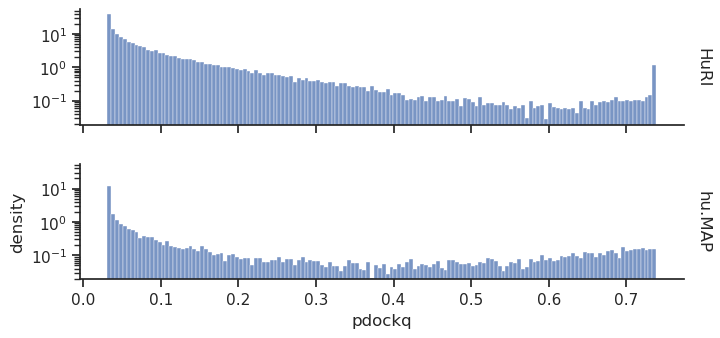

In [462]:
sn = sns.displot(
    data=mp,
    x='pdockq',
    row='dataset',
    # bins=100,
    stat='density', common_norm=True,
    height=1.8, aspect=4,
    facet_kws=dict(margin_titles=True),
)

sn.set(yscale='log', ylabel=None)
sn.axes.flatten()[-1].set(ylabel='density')
sn.set_titles(row_template='{row_name}')
# this one is a bit useless - look at the margin plots of the final one!

In [461]:
mp.head()

,ida,idb,pdockq,dataset,prob,hash_A,hash_B,za,zb,da,db,zc,dc,capri
0,O14964,A0A024R0Y4,0.077304,HuRI,1.0,CRC-DD64167A19DCF030,CRC-27D3F4F4D5EFF3C8,6.937132,11.84117,0.516088,0.158014,6.937132,0.516088,incorrect
1,O15287,A0A024R0Y4,0.038752,HuRI,1.0,CRC-4BC7475472AC3C84,CRC-27D3F4F4D5EFF3C8,11.711823,11.84117,0.127010,0.158014,11.711823,0.158014,incorrect
2,O60573,A0A024R0Y4,0.034888,HuRI,1.0,CRC-3D3075BFA48B3C12,CRC-27D3F4F4D5EFF3C8,9.707791,11.84117,0.334694,0.158014,9.707791,0.334694,incorrect
3,O75431,A0A024R0Y4,0.075548,HuRI,1.0,CRC-3A2EF476F1C78465,CRC-27D3F4F4D5EFF3C8,12.701179,11.84117,0.087452,0.158014,11.841170,0.158014,incorrect
4,O75528,A0A024R0Y4,0.730883,HuRI,1.0,CRC-C86153CFA83F9226,CRC-27D3F4F4D5EFF3C8,8.650670,11.84117,0.388889,0.158014,8.650670,0.388889,medium


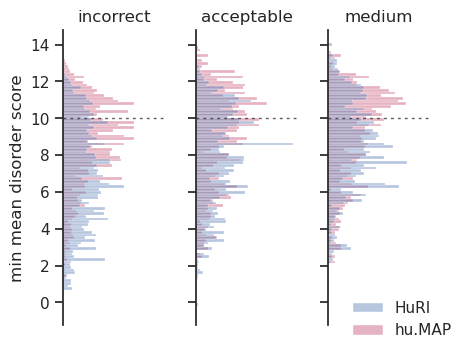

In [512]:
sn = sns.displot(
    data=mp,
    y='zc',
    hue='dataset',
    col='capri', col_order=capris[:-1],
    palette={'HuRI': '#4c72b0', 'hu.MAP': '#c14168'},
    bins=100,
    alpha=.4,
    stat='density', common_norm=False,
    height=4, aspect=.4,
    facet_kws=dict(margin_titles=True),
)

sn.set(yscale='linear', xlabel=None, xticks=[])
sn.despine(bottom=True)
sn.axes.flatten()[0].set(xlabel=None, ylabel='min mean disorder score')
for ax in sn.axes.flatten():
    ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
sn.set_titles(col_template='{col_name}')
sns.move_legend(sn, loc='lower right', frameon=False,
                bbox_to_anchor=(.8, .1),
                title=None, ncol=1)
sn.savefig('plots/chezods_by_capri_and_dataset.pdf')
# this complements the final one well

In [ ]:
import matplotlib.transforms as transforms

g = sns.JointGrid(data=mp,
                  x='pdockq', y='zc',
                  # hue='label',
                  marginal_ticks=True, height=2 * h,
                  # space=0,
                  ratio=6,
                  )

g.ax_joint.set(  # xlim=(ratio - 4, ratio + 4),
    # ylim=(0, 14),
    # xlim=(.23, None),
    ylabel='lower avg. CheZOD among the protein pair',
    xlabel='pDockQ of the interface',
    xscale='log', yscale='linear',
)

g.plot_joint(sns.scatterplot, legend=False,
             s=1, alpha=1, rasterized=True,
             )
# g.plot_joint(sns.kdeplot, legend=False,
#              # s=25, alpha=.1, rasterized=True,
#              )
# g.plot_joint(sns.histplot,
#              # s=25, alpha=.1, rasterized=True,
#              )
# g.plot_marginals(sns.histplot, multiple='fill')
g.plot_marginals(sns.kdeplot, warn_singular=False,
                 cut=0,
                 # multiple='fill',
                 # bw_adjust=.2,
                 )

g.ax_marg_x.set(xticks=[], yscale='log')
g.ax_marg_y.set(xticks=[])

trans = transforms.blended_transform_factory(
    g.ax_marg_x.transData, g.ax_marg_x.transAxes)
g.ax_marg_x.text(.03, .1, 'no docking',
                 ha='left', va='bottom', transform=trans)
g.ax_marg_x.text(.23 * 1.05, .45, 'acceptable',
                 ha='left', va='center', transform=trans)
g.ax_marg_x.text(.5 * 1.05, .9, 'medium',
                 ha='left', va='top', transform=trans)
g.ax_marg_x.text(.8 * 1.05, .1, 'high',
                 ha='left', va='bottom', transform=trans)


g.ax_joint.set(xticks=[.1, .23, .5, .8],
               xticklabels=['.1', '.23', '.5', '.8'])

g.refline(x=.23, lw=1, alpha=.5, zorder=0)
g.refline(x=.5, lw=1, alpha=.5, zorder=0)
g.refline(x=.8, lw=1, alpha=.5, zorder=0)
# g.refline(y=10, lw=1, alpha=.5, zorder=0)

thr = 10
g.refline(y=thr, lw=1, alpha=.5, zorder=0)
ll = len(mp.loc[mp.zc >= thr])
trans = transforms.blended_transform_factory(
    g.ax_marg_y.transAxes, g.ax_marg_y.transData)
g.ax_marg_y.text(1.1, thr, f'{ll} / {len(mp)}',
                 ha='left', va='bottom',
                 rotation=90,
                 transform=trans)

# sns.move_legend(g.ax_joint, loc='lower right', frameon=False,
#                 bbox_to_anchor=(1.2, -.1),
#                 title=None, labels=['known PPI', 'negative'], ncol=1)
g.ax_marg_y.legend(title=None, labels=['known PPI'],
                  bbox_to_anchor=(1.1, -.05), frameon=False)
# g.savefig('plots/chezod_huintaf.pdf')

In [ ]:
spearmanr(mp.pdockq, mp.zc)

In [ ]:
len(mp)

In [ ]:
g = sns.JointGrid(data=mp,
                  x='pdockq', y='zc',
                  marginal_ticks=True, height=4,
                  ratio=6,
                  )

ax, top, right = g.ax_joint, g.ax_marg_x, g.ax_marg_y
ax.set(xscale='log', yscale='linear')
top.set(yscale='log')
top.set(yticks=[])
right.set(xticklabels=[])

ax.set(xticks=[.1, .23, .5, .8], xticklabels=['.1', '.23', '.5', '.8'])
g.refline(x=.23, lw=1, alpha=.5, zorder=0)
g.refline(x=.5, lw=1, alpha=.5, zorder=0)
g.refline(x=.8, lw=1, alpha=.5, zorder=0)

g.plot_joint(sns.scatterplot, s=1, alpha=.4, rasterized=True)
g.plot_marginals(sns.histplot)


In [ ]:
sn = sns.relplot(
    data=mp,
    kind='scatter',
    x='pdockq',
    y='zc',
    hue='prob',
    col='dataset',
    height=3,
    aspect=.9,
    s=1,
    alpha=.4,
)

sn.set(xscale='linear')
sn.set_titles(col_template='{col_name}')
sn.set(xticks=[.1, .23, .5, .8], xticklabels=['.1', '.23', '.5', '.8'])
for ax in sn.axes.flatten():
    for l in [.23, .5]:
        ax.axvline(x=l, dashes=(2, 3), c='.5', lw=1, alpha=.5, zorder=0)

In [ ]:
p, q = mp.loc[mp.dataset == 'hu.MAP', ['pdockq', 'prob']].T.values
spearmanr(p, q)

In [ ]:
ours = pd.read_csv('scores.tsv', sep='\t', header=0)
ours['zc'] = ours[['za', 'zb']].min(axis=1)
ours['dc'] = ours[['da', 'db']].max(axis=1)
ours.head()

## matplotlib FTW

In [ ]:
ours.columns

In [ ]:
mp.columns

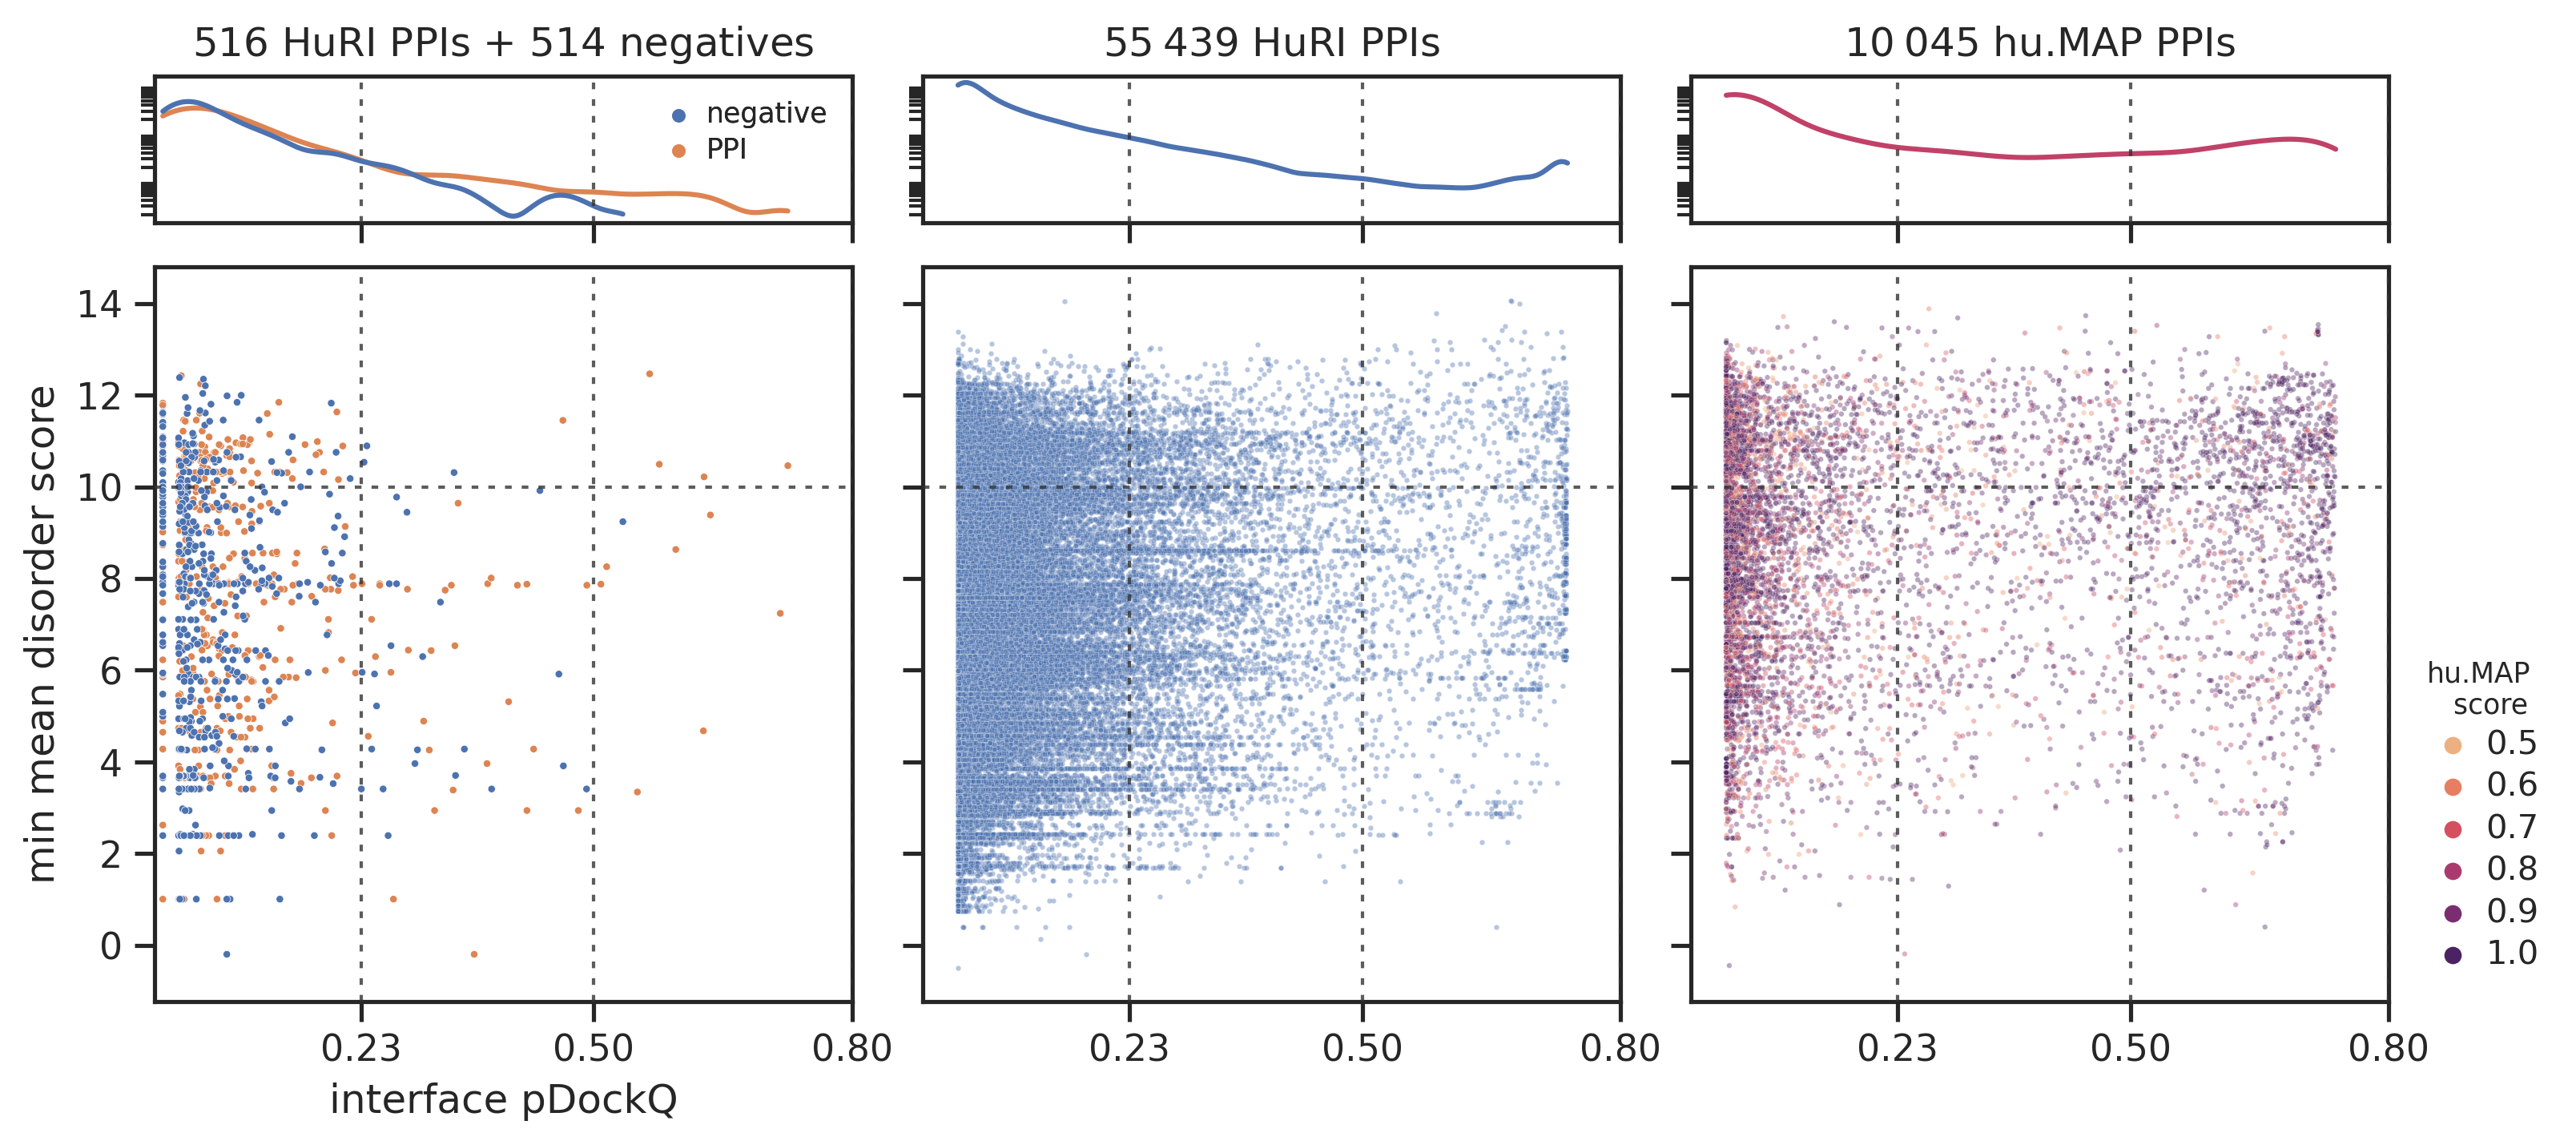

In [513]:
with mpl.rc_context({'figure.dpi': 300}):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row',
                             gridspec_kw=dict(height_ratios=[1, 5],
                                              wspace=.1, hspace=.1,
                                              ),
                             figsize=(12, 5))

    sns.kdeplot(data=ours,
                x='pdockq',
                hue='label', palette='deep',
                # bins=15,
                cut=0, clip=(0, .8),
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 0],
                )
    sns.kdeplot(data=mp.loc[mp.dataset == 'HuRI'],
                x='pdockq',
                # bins=15,
                cut=0, clip=(0, .8),
                color='#4c72b0',
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 1],
                )
    sns.kdeplot(data=mp.loc[mp.dataset == 'hu.MAP'],
                x='pdockq',
                # bins=15,
                cut=0, clip=(0, .8),
                color='#c14168',
                # bw_adjust=.5,
                legend=False,
                ax=axes[0, 2],
                )

    axes[0, 0].set(yscale='log', xscale='linear', ylabel=None, xlim=(-.01, None))
    axes[0, 0].set(yticks=[], xticks=[.23, .5, .8])

    s = 5
    al = 1

    sns.scatterplot(data=ours,
                    x='pdockq',
                    y='zc',
                    hue='label', palette='deep',
                    legend=True,
                    s=s, alpha=al,
                    ax=axes[1, 0],
                    )

    handles, labels = axes[1, 0].get_legend_handles_labels()
    l1 = list(handles), ['negative', 'PPI']
    l1 = axes[0, 0].legend(*l1,
                           handletextpad=0, labelspacing=.3,
                           markerscale=.5, fontsize='x-small',
                           bbox_to_anchor=(1, 1), loc='upper right',
                           frameon=False)
    axes[0, 0].add_artist(l1)
    axes[1, 0].get_legend().remove()

    sns.scatterplot(data=mp.loc[mp.dataset == 'HuRI'],
                    x='pdockq',
                    y='zc',
                    color='#4c72b0',
                    legend=True,
                    s=s / 2, alpha=al * .4,
                    ax=axes[1, 1],
                    rasterized=True,
                    )
    sns.scatterplot(data=mp.loc[mp.dataset == 'hu.MAP'],
                    x='pdockq',
                    y='zc',
                    hue='prob', hue_norm=(.5, 1), palette='flare',
                    legend=True,
                    s=s / 2, alpha=al * .4,
                    ax=axes[1, 2],
                    rasterized=True,
                    )
    l1 = axes[1, 2].get_legend_handles_labels()
    l1 = axes[1, 2].legend(*l1,
                           title='hu.MAP\n   score', title_fontsize='x-small',
                           handletextpad=0, labelspacing=.3,
                           markerscale=.7, fontsize='small',
                           bbox_to_anchor=(1, 0), loc='lower left',
                           frameon=False)
    axes[1, 2].add_artist(l1)
    axes[1, 2].get_legend().remove()

    for ax in axes.flatten():
        for l in [.23, .5, .8]:
            ax.axvline(x=l, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
        if ax != axes[1, 0]:
            ax.set(xlabel='')
        else:
            ax.set(ylabel='min mean disorder score', xlabel='interface pDockQ')
    for ax in axes[1, :]:
        ax.axhline(y=10, dashes=(2, 3), c='.2', lw=1, alpha=.8, zorder=99)
    for ax, t in zip(axes[0, :],
                     ['$516$ HuRI PPIs + $514$ negatives', '$55\>439$ HuRI PPIs', '$10\>045$ hu.MAP PPIs']):
        ax.set_title(t)

In [514]:
fig.savefig('plots/chezod_all.pdf')

In [431]:
ours.label.value_counts()

1    516
0    514
Name: label, dtype: int64

In [432]:
mp.dataset.value_counts()

HuRI      55439
hu.MAP    10045
Name: dataset, dtype: int64

In [433]:
ppal = sns.color_palette('flare', 5)
print(ppal.as_hex())

['#e98768', '#de5d5c', '#c14168', '#9a3670', '#722c6e']


In [477]:
ppal = sns.color_palette('deep', 5)
print(ppal.as_hex())

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']


In [ ]:
%matplotlib inline
ppal = sns.color_palette('flare', 5)
print(ppal.as_hex())
ppal

In [ ]:
plt.close('all')
